In [1]:
!pip install jovian numpy pandas matplotlib seaborn sklearn xgboost scikit-optimize openpyxl --quiet

## Importing the Libraries

In [2]:
import jovian

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.simplefilter('ignore')

<IPython.core.display.Javascript object>

## Reading the dataset

In [3]:
train_df = pd.read_excel('https://github.com/Santhosh-03/Datasets/blob/main/Flight%20Ticket%20Price%20Prediction/Data_Train.xlsx?raw=true')
test_df = pd.read_excel('https://github.com/Santhosh-03/Datasets/blob/main/Flight%20Ticket%20Price%20Prediction/Test_set.xlsx?raw=true')

In [4]:
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [6]:
print('The training dataset has {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print('The testing dataset has {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

The training dataset has 10683 rows and 11 columns
The testing dataset has 2671 rows and 10 columns


In [7]:
train_df.isna().sum() # checking na values in training data

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [8]:
test_df.isna().sum() # checking na values in testing data

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

## Data cleaning and Preprocessing

In [9]:
# changing the column names to lower case

train_df.columns = train_df.columns.str.lower() 
test_df.columns = test_df.columns.str.lower()

### Dropping na values

In [10]:
train_df.dropna(inplace = True) # dropping the na values

### Route and Total_Stops

In [11]:
# inspecting the route column

train_df['route'][:5]

0                BLR → DEL
1    CCU → IXR → BBI → BLR
2    DEL → LKO → BOM → COK
3          CCU → NAG → BLR
4          BLR → NAG → DEL
Name: route, dtype: object

In [12]:
train_df['total_stops'][:5]

0    non-stop
1     2 stops
2     2 stops
3      1 stop
4      1 stop
Name: total_stops, dtype: object

We can see that the number of places between the source and destination in the `route` column is the number of stops values.

In [13]:
# function to clean the total_stops column

def clean_total_stops_col(data, column):
    cleaned_values = data[column].apply(lambda x: x.split('stop')[0].strip()) # splitting the string at stop and getting the first element of the splitted list
    cleaned_values = [0 if val == 'non-' else val for val in cleaned_values] # replacing non- with 0 in the list
    cleaned_values = list(map(int, cleaned_values)) # changing the datatype of the list
    return cleaned_values # return the list

In [14]:
train_df['total_stops'] = clean_total_stops_col(train_df, 'total_stops')
test_df['total_stops'] = clean_total_stops_col(test_df, 'total_stops')

In [15]:
print(train_df['total_stops'].value_counts())
print(test_df['total_stops'].value_counts())

1    5625
0    3491
2    1520
3      45
4       1
Name: total_stops, dtype: int64
1    1431
0     849
2     379
3      11
4       1
Name: total_stops, dtype: int64


### Duration

In [16]:
train_df['duration'][:5]

0    2h 50m
1    7h 25m
2       19h
3    5h 25m
4    4h 45m
Name: duration, dtype: object

In [17]:
def clean_duration_col(data, column):
    cleaned_values = [] # list to store the cleaned values
    
    for val in data[column]: # iterating through all the values
        splited_duration = val.split(' ') # splitting the values on a space
        
        if(len(splited_duration) > 1): # if duration in hours and minutes
            # getting the hour and minute values from the splitted list
            hours, minutes = int(splited_duration[0].replace('h', '')), int(splited_duration[1].replace('m', ''))
            hours_to_minutes = hours * 60 # converting hours to minutes
            total_minutes = hours_to_minutes + minutes # finding the total_minutes
            cleaned_values.append(total_minutes*60) # converting to seconds 
            #print(total_minutes)
        
        elif('h' in val): # if duration only in hours
            hours = int(splited_duration[0].replace('h', '')) # getting the hour value
            hours_to_minutes = hours * 60 # converting hours to minutes
            cleaned_values.append(hours_to_minutes*60) # converting to seconds
            #print(hours_to_minutes)
        
        elif('m' in val): # if duration only in minutes
            minutes = int(splited_duration[0].replace('m', '')) # getting the minute values
            cleaned_values.append(minutes*60) # converting to seconds
    
    return cleaned_values

In [18]:
train_df['duration'] = clean_duration_col(train_df, 'duration')
train_df['duration'].head()

0    10200
1    26700
2    68400
3    19500
4    17100
Name: duration, dtype: int64

In [19]:
test_df['duration'] = clean_duration_col(test_df, 'duration')
test_df['duration'].head()

0    39300
1    14400
2    85500
3    46800
4    10200
Name: duration, dtype: int64

### Date_of_Journey

In [20]:
# inspecting the date_of_journey column

train_df['date_of_journey'].head()

0    24/03/2019
1     1/05/2019
2     9/06/2019
3    12/05/2019
4    01/03/2019
Name: date_of_journey, dtype: object

In [21]:
# getting the month and day for each date

train_df['month'] = pd.to_datetime(train_df['date_of_journey']).dt.month
train_df['day'] = pd.to_datetime(train_df['date_of_journey']).dt.day

In [22]:
# getting the month and day for each date

test_df['month'] = pd.to_datetime(test_df['date_of_journey']).dt.month
test_df['day'] = pd.to_datetime(test_df['date_of_journey']).dt.day

### Additional_Info

In [23]:
# inspecting additional info column

train_df['additional_info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

* We can see that `No info` is repeated twice with a different spelling. We can make that a single category.
* Also there are 3 layover category which can be considered as a single category.

In [24]:
train_df['additional_info'].replace('No info', 'No Info', inplace = True)
train_df.replace(['1 Long layover', '2 Long layover', '1 Short layover'], 'Layover', inplace = True)

In [25]:
train_df['additional_info'].value_counts()

No Info                         8347
In-flight meal not included     1982
No check-in baggage included     320
Layover                           21
Change airports                    7
Business class                     4
Red-eye flight                     1
Name: additional_info, dtype: int64

Here there are 3 categories that have values less than 10. We can consider them as one whole category since they may cause problems when performing splitting of the data.

In [26]:
train_df.replace(['Change airports', 'Business class', 'Red-eye flight'], 'Other', inplace = True)

In [27]:
train_df['additional_info'].value_counts()

No Info                         8347
In-flight meal not included     1982
No check-in baggage included     320
Layover                           21
Other                             12
Name: additional_info, dtype: int64

In [28]:
test_df['additional_info'].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
1 Long layover                     1
Business class                     1
Change airports                    1
Name: additional_info, dtype: int64

In [29]:
test_df.replace(['1 Long layover'], 'Layover', inplace = True)
test_df.replace(['Change airports', 'Business class', 'Red-eye flight'], 'Other', inplace = True)

In [30]:
test_df['additional_info'].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Other                              2
Layover                            1
Name: additional_info, dtype: int64

### Airline

In [31]:
# inspecting the airline column

train_df['airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [32]:
train_df['airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: airline, dtype: int64

Since we have airline repeated in a different way we can replace them to make a single category.

In [33]:
# replacing the repeated airlines

train_df['airline'].replace(['Multiple carriers Premium economy', 'Jet Airways Business', 'Vistara Premium economy'],
                            ['Multiple carriers', 'Jet Airways', 'Vistara'], inplace = True)

In [34]:
train_df['airline'].value_counts()

Jet Airways          3855
IndiGo               2053
Air India            1751
Multiple carriers    1209
SpiceJet              818
Vistara               482
Air Asia              319
GoAir                 194
Trujet                  1
Name: airline, dtype: int64

Since we have only 1 value for `Trujet` airline we can drop the row containing that airline.

In [35]:
idx_to_drop = train_df[train_df['airline'] == 'Trujet'].index # getting the index value of the airline row
train_df.drop(index = idx_to_drop, inplace = True) # dropping the index

In [36]:
test_df['airline'].value_counts()

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: airline, dtype: int64

In [37]:
# replacing the repeated airlines

test_df['airline'].replace(['Multiple carriers Premium economy', 'Jet Airways Business', 'Vistara Premium economy'],
                            ['Multiple carriers', 'Jet Airways', 'Vistara'], inplace = True)

In [38]:
test_df['airline'].value_counts()

Jet Airways          899
IndiGo               511
Air India            440
Multiple carriers    350
SpiceJet             208
Vistara              131
Air Asia              86
GoAir                 46
Name: airline, dtype: int64

### Departure Time Category

In [39]:
def dept_time_cat(df, col):
    hour = df[col].apply(lambda x:int(x.split(':')[0]))
    hour_cat = []
    for h in hour:
        if h >= 0 and h < 6:
            hour_cat.append('midnight')
        elif h >= 6 and h < 12:
            hour_cat.append('morning')
        elif h >= 12 and h < 18:
            hour_cat.append('afternoon')
        elif h >= 18 and h < 24:
            hour_cat.append('night')
    return hour_cat

In [40]:
train_df['dep_time_cat'] = dept_time_cat(train_df, 'dep_time')
train_df['dep_time_cat']

0            night
1         midnight
2          morning
3            night
4        afternoon
           ...    
10678        night
10679        night
10680      morning
10681      morning
10682      morning
Name: dep_time_cat, Length: 10681, dtype: object

In [41]:
test_df['dep_time_cat'] = dept_time_cat(test_df, 'dep_time')
test_df['dep_time_cat']

0       afternoon
1         morning
2           night
3         morning
4           night
          ...    
2666        night
2667    afternoon
2668        night
2669     midnight
2670     midnight
Name: dep_time_cat, Length: 2671, dtype: object

### Correlation plot

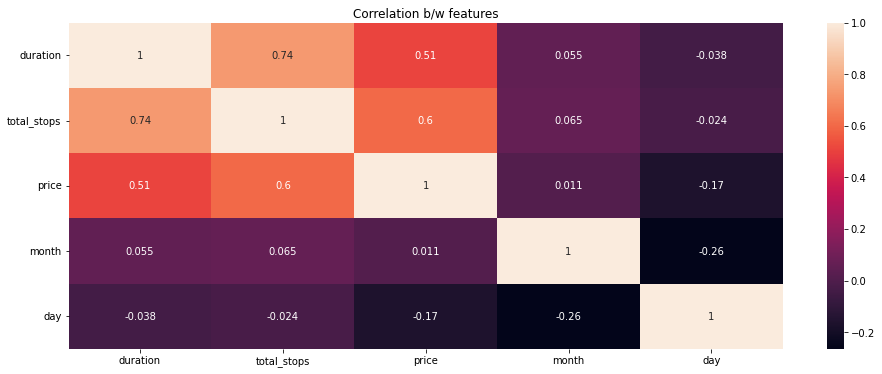

In [42]:
plt.figure(figsize = (16, 6)) # figure size

# heatmap
sns.heatmap(train_df.corr(), annot = True)
_ = plt.yticks(rotation = 0) # formatting the y-label
plt.title('Correlation b/w features') # title of the plot
plt.show()

__INSIGHTS :__

* Here we can see that duration and total_stops have a correlation of 0.5 and 0.6 with target feature price respectively.

## Exploratory Data Analysis

In [44]:
# setting the style for all the plots
sns.set_theme(style = 'darkgrid', context = 'poster', font_scale = 0.6, color_codes = True)

### Airline

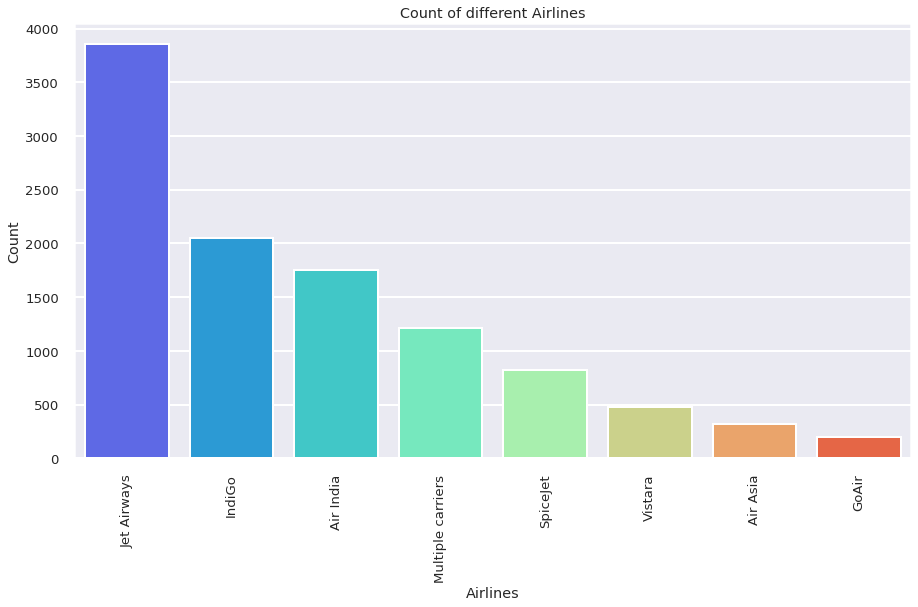

In [45]:
plt.figure(figsize = (15, 8)) # setting the figure size

# countplot for airline column
sns.countplot(train_df['airline'], order = train_df['airline'].value_counts().index, palette = 'rainbow')
# formatting the xticks
_ = plt.xticks(rotation = 90,
               horizontalalignment = 'center',
               fontweight = 'light')
plt.xlabel('Airlines') # x-label
plt.ylabel('Count') # y-label
plt.title('Count of different Airlines') # title of the plot
plt.show()

__INSIGHTS :__

* Here we can see that Jet Airways, IndiGo, Air India are the top three airline having the most passengers.

### Airline Vs Price

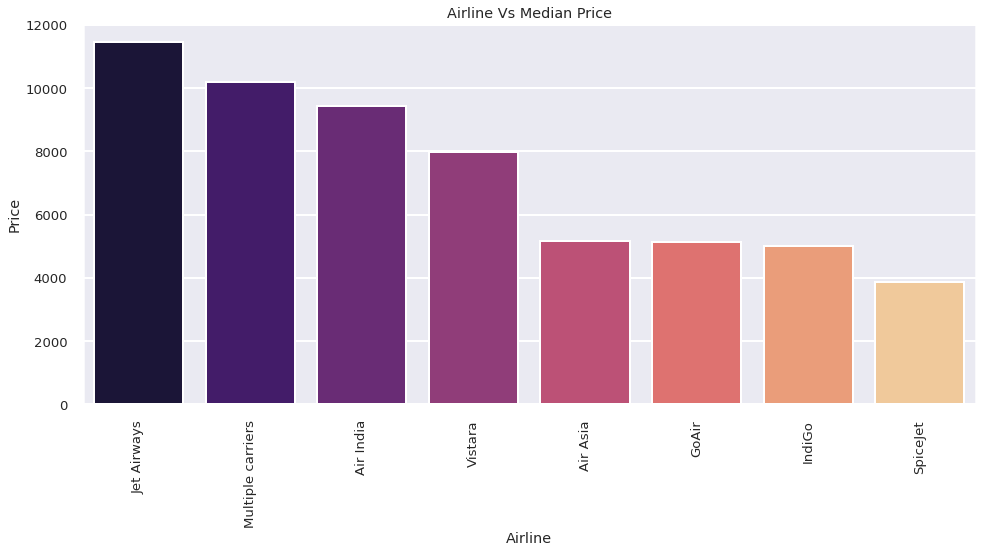

In [47]:
plt.figure(figsize = (16, 7)) # figure size

# grouping price with respect to airlines and getting the median price and sorting in descending order based on price
grouped_data = train_df.groupby('airline')['price'].agg(np.median).reset_index().sort_values(
                                                                by = 'price', ascending = False)
# barplot for airline and price
sns.barplot(grouped_data['airline'], grouped_data['price'], palette = 'magma')
# formatting the xticks
_ = plt.xticks(rotation = 90,
              horizontalalignment = 'center', 
              fontweight = 'light')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.title('Airline Vs Median Price') # title
plt.show()

__INSIGHTS :__

* Here we can see that Jet Airways, Multiple carriers and Air India are the top 3 costliest airlines.

### Duration Vs Price 

We normally know that the longer the duration for the travel higher will be the price of the travel. Lets check this out.

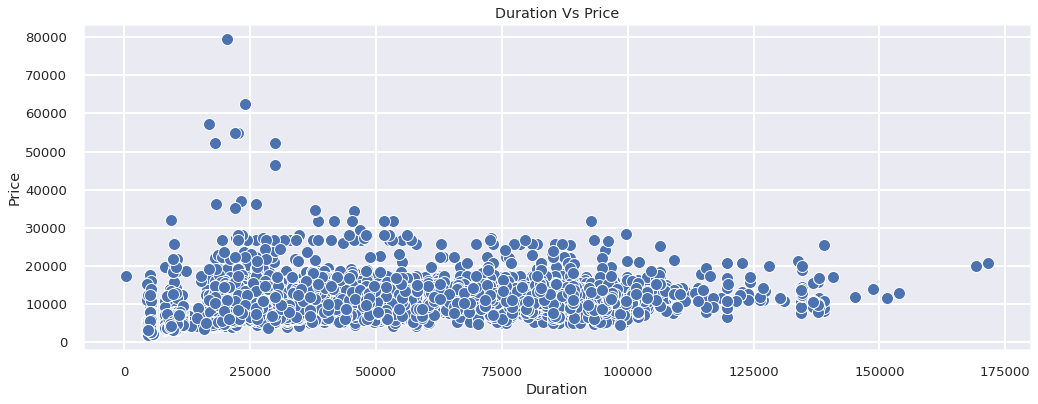

In [48]:
plt.figure(figsize = (17, 6)) # figure size

# scatterplot for duration and price
sns.scatterplot(train_df['duration'], train_df['price'])
plt.xlabel('Duration')
plt.ylabel('Price')
plt.title('Duration Vs Price') # title of the plot
plt.show()

__INSIGHTS__:

* We can see that there is no linear relationship between the duration and price of the travel.

### Month Vs Price

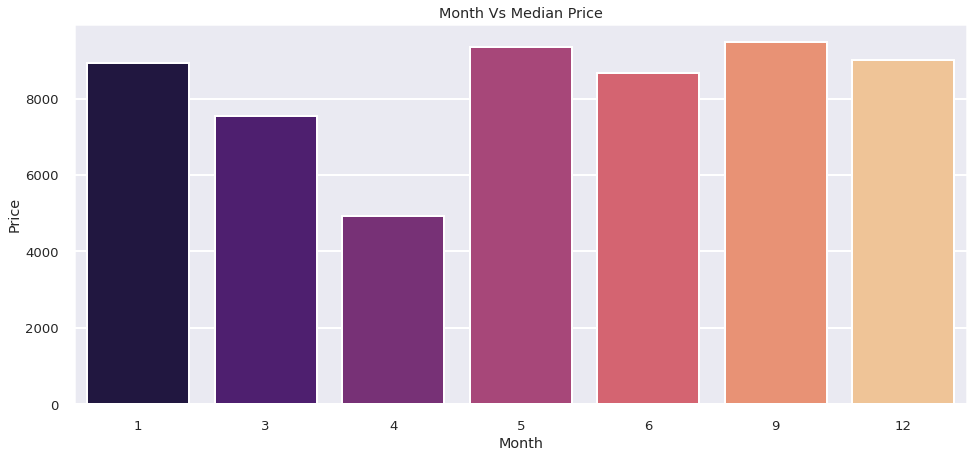

In [49]:
plt.figure(figsize = (16, 7)) # figure size

# grouping price with respect to airlines and getting the median price and sorting in descending order based on price
grouped_data = train_df.groupby('month')['price'].agg(np.median).reset_index().sort_values(
                                                                by = 'price', ascending = False)
# barplot for airline and price
sns.barplot(grouped_data['month'], grouped_data['price'], palette = 'magma')
# formatting the xticks
_ = plt.xticks(horizontalalignment = 'center', 
              fontweight = 'light')
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Month Vs Median Price') # title
plt.show()

__INSIGHTS :__

* Here we can see that September, May and December months have a higher price.

### Source Vs Price

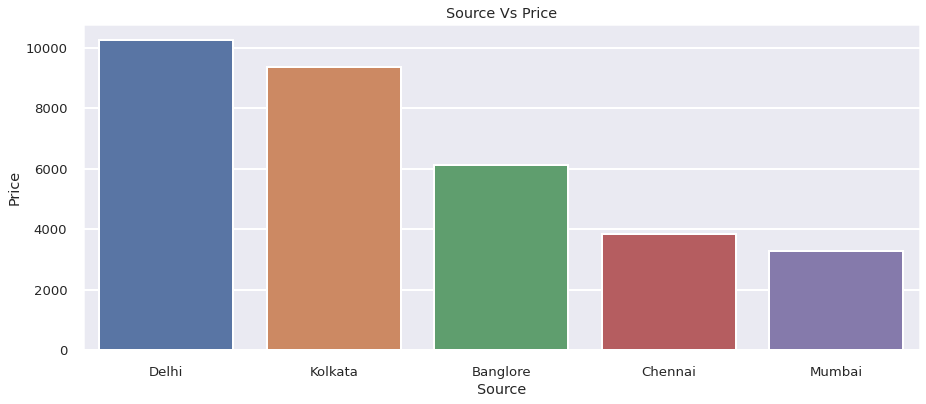

In [50]:
plt.figure(figsize = (15, 6)) # figure size

# grouping price with source and getting their median
grouped_data = train_df.groupby('source')['price'].agg(np.median).reset_index().sort_values(
                                                                by = 'price', ascending = False)
# barplot
sns.barplot(grouped_data['source'], grouped_data['price'])
plt.title('Source Vs Price') # title of the plot
plt.xlabel('Source') # x-label
plt.ylabel('Price') # y-lablel
plt.show()

### Number of stops Vs Price

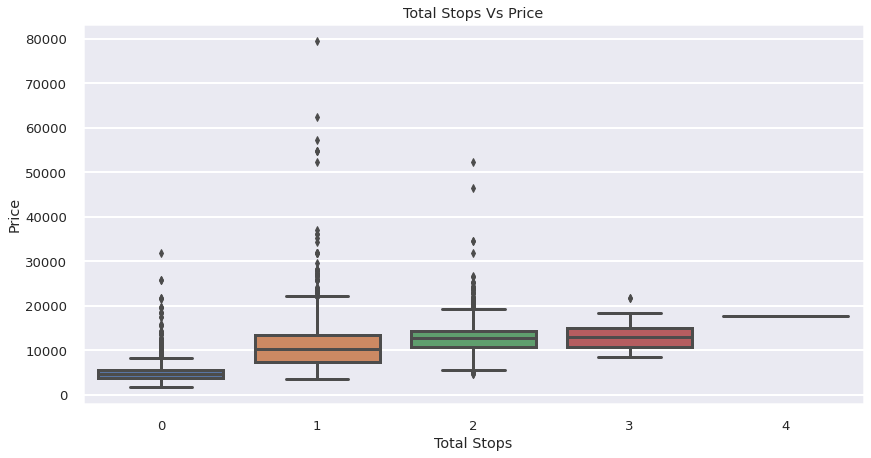

In [51]:
plt.figure(figsize = (14, 7)) # figure size

# boxplot
sns.boxplot(train_df['total_stops'], train_df['price'])
plt.title('Total Stops Vs Price') # title of the plot
plt.xlabel('Total Stops') # x-label
plt.ylabel('Price') # y-label
plt.show()

In [52]:
train_df.groupby('total_stops')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
total_stops,,,,,,,,
0,3491.0,5024.900315,2077.586642,1759.0,3858.0,4667.0,5678.0,31945.0
1,5624.0,10595.271159,4281.161439,3480.0,7480.0,10262.0,13364.0,79512.0
2,1520.0,12715.807895,3383.983396,4647.0,10676.0,12760.0,14237.0,52285.0
3,45.0,13112.000000,2963.224265,8607.0,10703.0,12954.0,14960.0,21829.0
4,1.0,17686.000000,NaN,17686.0,17686.0,17686.0,17686.0,17686.0


__INSIGHTS :__

* Here we can clearly see that there is a variation in the price for different number of stops.
* We can also see that when stops are included as the number of stops increases the maximum price decreases.

### Duration

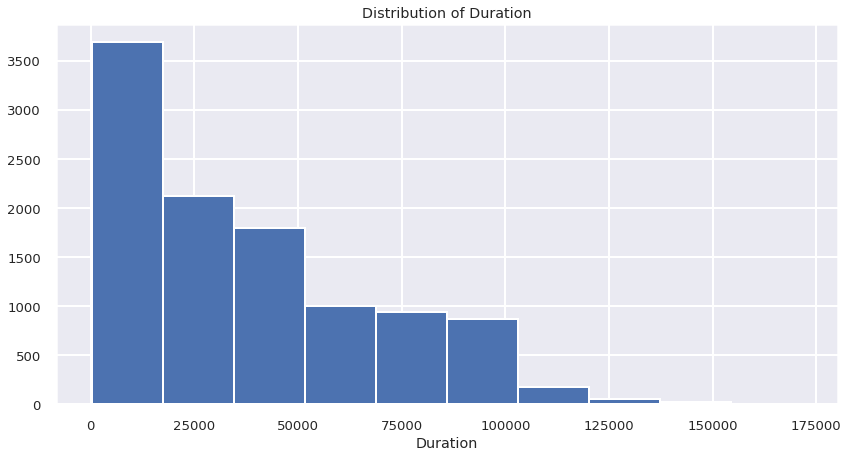

In [53]:
plt.figure(figsize = (14, 7)) # figure size

plt.hist(train_df['duration'])
plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.show()

__INSIGHTS :__

* Here we can see that the distribution is positively skewed as it has a long right tail.

## Preparing the data for training

We'll perform the following steps to prepare the dataset for training:

* Create a train/test/validation split.
* Identify input and target columns.
* Identify numeric and categorical columns.
* Impute (fill) missing numeric values.
* Scale numeric values.
* Encode categorical columns to one-hot vectors.

In [54]:
train_df.head(1)

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price,month,day,dep_time_cat
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,10200,0,No Info,3897,3,24,night


In [55]:
train_df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'route',
       'dep_time', 'arrival_time', 'duration', 'total_stops',
       'additional_info', 'price', 'month', 'day', 'dep_time_cat'],
      dtype='object')

In [56]:
# we can drop the columns that we dont require for building the model

columns_to_drop = ['date_of_journey', 'route' , 'dep_time' , 'arrival_time'] 
train_df.drop(columns = columns_to_drop, inplace = True)

In [57]:
train_df = train_df.reset_index().drop(columns='index')
train_df.head(2)

,airline,source,destination,duration,total_stops,additional_info,price,month,day,dep_time_cat
0,IndiGo,Banglore,New Delhi,10200,0,No Info,3897,3,24,night
1,Air India,Kolkata,Banglore,26700,2,No Info,7662,1,5,midnight


In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [59]:
X = train_df.drop(columns = ['price']) # getting the independent features
y = train_df['price'] # getting the dependent features

In [60]:
# seperating the numerical and categorical columns

numerical_features = list(X.select_dtypes(include = np.number).columns)
categorical_features = list(X.select_dtypes(exclude = np.number).columns)

### Outliers Removal

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, q_lower, q_upper):
        self.q_lower = q_lower
        self.q_upper = q_upper
    
    def fit(self, X, y=None):
        self.upper = np.percentile(X, self.q_upper, axis=0)
        self.lower = np.percentile(X, self.q_lower, axis=0)
        
        return self
    
    def transform(self, X):
        columns = X.columns
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        Xt = X.copy()
        ind_lower = X < self.lower
        ind_upper = X > self.upper
        
        for i in range(X.shape[-1]):
            Xt[ind_lower[:, i], i] = self.lower[i]
            Xt[ind_upper[:, i], i] = self.upper[i]
        
        return pd.DataFrame(Xt, columns = columns)

<AxesSubplot:xlabel='duration'>

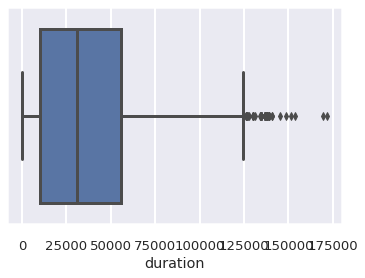

In [62]:
sns.boxplot(train_df['duration']) # checking for outliers in the duration column

Here we can see that there are some outliers present in the column. Let's try to remove them using the class defined above.

In [63]:
dur = pd.DataFrame(X['duration'])
replacer = OutlierReplacer(5, 95) # setting the upper and lower bound for outliers
replacer.fit(dur)
dur_t = replacer.transform(dur)

<AxesSubplot:xlabel='duration'>

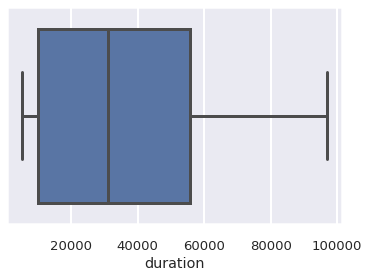

In [64]:
sns.boxplot(dur_t['duration'])

Here we can see that the outliers has been removed. So we can continue to build the model.

In [67]:
X['duration'] = dur_t['duration']
#X['duration'].fillna(X['duration'].median(), inplace = True)

In [68]:
scaler = StandardScaler() # scaler object

In [69]:
# encoding categoical values

encoded_df = pd.get_dummies(X[categorical_features], drop_first = True)
encoded_df

,airline_Air India,airline_GoAir,airline_IndiGo,airline_Jet Airways,airline_Multiple carriers,airline_SpiceJet,airline_Vistara,source_Chennai,source_Delhi,source_Kolkata,...,destination_Hyderabad,destination_Kolkata,destination_New Delhi,additional_info_Layover,additional_info_No Info,additional_info_No check-in baggage included,additional_info_Other,dep_time_cat_midnight,dep_time_cat_morning,dep_time_cat_night
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10676,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
10677,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
10678,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
10679,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [70]:
X.drop(columns = categorical_features, inplace = True) # dropping the categorical values

In [71]:
X = X.join(encoded_df)

In [72]:
# performing train test split with a test size of 30%

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [73]:
X_train = scaler.fit_transform(X_train, y_train)
X_val = scaler.transform(X_val)

## Model 1 : Linear Regression

### Building the model

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [75]:
linear_regressor = LinearRegression() # linear regression object

In [76]:
linear_regressor.fit(X_train, y_train)

LinearRegression()

### Making predictions on training and validation data

In [77]:
train_pred_1 = linear_regressor.predict(X_train) # prediction on training data
val_pred_1 = linear_regressor.predict(X_val) # prediction on validation data

### Evaluating the predictions

Since the problem is based on regression we can use the following metrics to evaluate the model.

* Mean Squared Error (MSE)
* Root Mean Squared Error(RMSE)
* Mean Absolute Error (MAE)
* R2 Score

In [78]:
# importing the metrics

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [79]:
# evaluating the predictions on training data

r2score_train_1 = r2_score(y_train, train_pred_1)
mse_train_1 = mean_squared_error(y_train, train_pred_1)
mae_train_1 = mean_absolute_error(y_train, train_pred_1)
rmse_train_1 = mean_squared_error(y_train, train_pred_1, squared = False)

# evaluating the predictions on validation data

r2score_val_1 = r2_score(y_val, val_pred_1)
mse_val_1 = mean_squared_error(y_val, val_pred_1)
mae_val_1 = mean_absolute_error(y_val, val_pred_1)
rmse_val_1 = mean_squared_error(y_val, val_pred_1, squared = False)

In [80]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_1)
print('The MSE on the training data is', mse_train_1)
print('The MAE on the training data is', mae_train_1)
print('The RMSE on the training data is', rmse_train_1)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_1)
print('The MSE on the validation data is', mse_val_1)
print('The MAE on the validation data is', mae_val_1)
print('The RMSE on the validation data is', rmse_val_1)

TRAINING
The R2 score on the training data is 0.6603392317657442
The MSE on the training data is 7089616.372664995
The MAE on the training data is 1768.7347066910552
The RMSE on the training data is 2662.633353029477
************************************************************
VALIDATION
The R2 score on the validation data is 0.6033594851027333
The MSE on the validation data is 9037506.25057478
The MAE on the validation data is 1928.7442634502588
The RMSE on the validation data is 3006.244542710187


* We can see that there even though the R2 score is low there is not much difference between the R2 score training and validation data.


## Model 2 : Lasso Regression

In [81]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_regressor = Lasso(max_iter = 10_000, random_state = 0)

### Building the model

In [82]:
lasso_regressor.fit(X_train, y_train)

Lasso(max_iter=10000, random_state=0)

### Making predictions on training and validation data

In [83]:
train_pred_2 = lasso_regressor.predict(X_train) # prediction on training data
val_pred_2 = lasso_regressor.predict(X_val) # prediction on validation data

### Evaluating the predictions

In [84]:
# evaluating the predictions on training data

r2score_train_2 = r2_score(y_train, train_pred_2)
mse_train_2 = mean_squared_error(y_train, train_pred_2)
mae_train_2 = mean_absolute_error(y_train, train_pred_2)
rmse_train_2 = mean_squared_error(y_train, train_pred_2, squared = False)

# evaluating the predictions on validation data

r2score_val_2 = r2_score(y_val, val_pred_2)
mse_val_2 = mean_squared_error(y_val, val_pred_2)
mae_val_2 = mean_absolute_error(y_val, val_pred_2)
rmse_val_2 = mean_squared_error(y_val, val_pred_2, squared = False)

In [85]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_2)
print('The MSE on the training data is', mse_train_2)
print('The MAE on the training data is', mae_train_2)
print('The RMSE on the training data is', rmse_train_2)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_2)
print('The MSE on the validation data is', mse_val_2)
print('The MAE on the validation data is', mae_val_2)
print('The RMSE on the validation data is', rmse_val_2)

TRAINING
The R2 score on the training data is 0.660355385577047
The MSE on the training data is 7089279.200003904
The MAE on the training data is 1767.2727235483117
The RMSE on the training data is 2662.5700366382675
************************************************************
VALIDATION
The R2 score on the validation data is 0.6037895467091381
The MSE on the validation data is 9027707.240362668
The MAE on the validation data is 1927.2966859532266
The RMSE on the validation data is 3004.6143247283285


* Here we can see that the R2 score for training and validation are same as the Linear Regression model.
* Let's try to tune some parameters to see if there an increase the performance of the model.

### Hyper parameter tuning

In [86]:
param_grid = {'alpha' : np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(lasso_regressor, param_grid, cv = 5, verbose = 1,
                           scoring = 'neg_mean_absolute_error', n_jobs = -1, error_score = 'raise')

In [87]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Lasso(max_iter=10000, random_state=0), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.1...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             scoring='neg_mean_absolute_error', verbose=1)

#### Making predictions on training and validation data

In [88]:
grid_search.best_params_

{'alpha': 17.47528400007683}

In [89]:
lasso_reg_tuned = grid_search.best_estimator_

train_pred_2 = lasso_reg_tuned.predict(X_train) # prediction on training data
val_pred_2 = lasso_reg_tuned.predict(X_val) # prediction on validation data

#### Evaluating the predictions

In [90]:
# evaluating the predictions on training data

r2score_train_2 = r2_score(y_train, train_pred_2)
mse_train_2 = mean_squared_error(y_train, train_pred_2)
mae_train_2 = mean_absolute_error(y_train, train_pred_2)
rmse_train_2 = mean_squared_error(y_train, train_pred_2, squared = False)

# evaluating the predictions on validation data

r2score_val_2 = r2_score(y_val, val_pred_2)
mse_val_2 = mean_squared_error(y_val, val_pred_2)
mae_val_2 = mean_absolute_error(y_val, val_pred_2)
rmse_val_2 = mean_squared_error(y_val, val_pred_2, squared = False)

In [91]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_2)
print('The MSE on the training data is', mse_train_2)
print('The MAE on the training data is', mae_train_2)
print('The RMSE on the training data is', rmse_train_2)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_2)
print('The MSE on the validation data is', mse_val_2)
print('The MAE on the validation data is', mae_val_2)
print('The RMSE on the validation data is', rmse_val_2)

TRAINING
The R2 score on the training data is 0.6596881410512525
The MSE on the training data is 7103206.35367324
The MAE on the training data is 1764.683309541031
The RMSE on the training data is 2665.184112528296
************************************************************
VALIDATION
The R2 score on the validation data is 0.6031864846258642
The MSE on the validation data is 9041448.089172538
The MAE on the validation data is 1930.1984392288896
The RMSE on the validation data is 3006.9000796788273


* Here also the R2 score are pretty much same for the training and validation data.
* Let's try out the next model.

## Model 3 : Ridge Regression

In [92]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge(random_state = 0)

### Building the model

In [93]:
ridge_regressor.fit(X_train, y_train)

Ridge(random_state=0)

### Making predictions on training and validation data

In [94]:
train_pred_3 = ridge_regressor.predict(X_train) # prediction on training data
val_pred_3 = ridge_regressor.predict(X_val) # prediction on validation data

### Evaluating the predictions

In [95]:
# evaluating the predictions on training data

r2score_train_3 = r2_score(y_train, train_pred_3)
mse_train_3 = mean_squared_error(y_train, train_pred_3)
mae_train_3 = mean_absolute_error(y_train, train_pred_3)
rmse_train_3 = mean_squared_error(y_train, train_pred_3, squared = False)

# evaluating the predictions on validation data

r2score_val_3 = r2_score(y_val, val_pred_3)
mse_val_3 = mean_squared_error(y_val, val_pred_3)
mae_val_3 = mean_absolute_error(y_val, val_pred_3)
rmse_val_3 = mean_squared_error(y_val, val_pred_3, squared = False)

In [96]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_3)
print('The MSE on the training data is', mse_train_3)
print('The MAE on the training data is', mae_train_3)
print('The RMSE on the training data is', rmse_train_3)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_3)
print('The MSE on the validation data is', mse_val_3)
print('The MAE on the validation data is', mae_val_3)
print('The RMSE on the validation data is', rmse_val_3)

TRAINING
The R2 score on the training data is 0.6603612871062363
The MSE on the training data is 7089156.019519499
The MAE on the training data is 1767.6407464286713
The RMSE on the training data is 2662.5469046609296
************************************************************
VALIDATION
The R2 score on the validation data is 0.6037811242599693
The MSE on the validation data is 9027899.14697369
The MAE on the validation data is 1927.2588423268892
The RMSE on the validation data is 3004.6462598738126


* Here we can see that the R2 score for training and validation are same as the previous two model.
* Let's try to tune some parameters to see if there an increase the performance of the model.

### Tuning Hyper parameters

In [97]:
param_grid = {'alpha' : np.logspace(-3, 3, 100)}

grid_search = GridSearchCV(ridge_regressor, param_grid, cv = 5, verbose = 1, n_jobs = -1, error_score = 'raise')

In [98]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, error_score='raise', estimator=Ridge(random_state=0),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.3...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             verbose=1)

In [99]:
grid_search.best_params_

{'alpha': 4.9770235643321135}

#### Making predictions on training and validation data

In [100]:
ridge_reg_tuned = grid_search.best_estimator_

train_pred_3 = ridge_reg_tuned.predict(X_train) # prediction on training data
val_pred_3 = ridge_reg_tuned.predict(X_val) # prediction on validation data

#### Evaluating the predictions

In [101]:
# evaluating the predictions on training data

r2score_train_3 = r2_score(y_train, train_pred_3)
mse_train_3 = mean_squared_error(y_train, train_pred_3)
mae_train_3 = mean_absolute_error(y_train, train_pred_3)
rmse_train_3 = mean_squared_error(y_train, train_pred_3, squared = False)

# evaluating the predictions on validation data

r2score_val_3 = r2_score(y_val, val_pred_3)
mse_val_3 = mean_squared_error(y_val, val_pred_3)
mae_val_3 = mean_absolute_error(y_val, val_pred_3)
rmse_val_3 = mean_squared_error(y_val, val_pred_3, squared = False)

In [102]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_3)
print('The MSE on the training data is', mse_train_3)
print('The MAE on the training data is', mae_train_3)
print('The RMSE on the training data is', rmse_train_3)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_3)
print('The MSE on the validation data is', mse_val_3)
print('The MAE on the validation data is', mae_val_3)
print('The RMSE on the validation data is', rmse_val_3)

TRAINING
The R2 score on the training data is 0.6603583142933486
The MSE on the training data is 7089218.0699677495
The MAE on the training data is 1767.471261142718
The RMSE on the training data is 2662.5585570964913
************************************************************
VALIDATION
The R2 score on the validation data is 0.6037624921006137
The MSE on the validation data is 9028323.683172876
The MAE on the validation data is 1927.4318036932816
The RMSE on the validation data is 3004.7169056623084


* Here also the model performance same as compared to the previous models.

## Model 4 : Decision Tree

In [103]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_reg = DecisionTreeRegressor(random_state = 0)

### Building the model

In [104]:
decision_tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

### Making predictions on training and validation data

In [105]:
train_pred_4 = decision_tree_reg.predict(X_train)
val_pred_4 = decision_tree_reg.predict(X_val)

### Evaluating the predictions

In [106]:
# evaluating the predictions on training data

r2score_train_4 = r2_score(y_train, train_pred_4)
mse_train_4 = mean_squared_error(y_train, train_pred_4)
mae_train_4 = mean_absolute_error(y_train, train_pred_4)
rmse_train_4 = mean_squared_error(y_train, train_pred_4, squared = False)

# evaluating the predictions on validation data

r2score_val_4 = r2_score(y_val, val_pred_4)
mse_val_4 = mean_squared_error(y_val, val_pred_4)
mae_val_4 = mean_absolute_error(y_val, val_pred_4)
rmse_val_4 = mean_squared_error(y_val, val_pred_4, squared = False)

In [107]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_4)
print('The MSE on the training data is', mse_train_4)
print('The MAE on the training data is', mae_train_4)
print('The RMSE on the training data is', rmse_train_4)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_4)
print('The MSE on the validation data is', mse_val_4)
print('The MAE on the validation data is', mae_val_4)
print('The RMSE on the validation data is', rmse_val_4)

TRAINING
The R2 score on the training data is 0.9919201783923405
The MSE on the training data is 168647.19424519574
The MAE on the training data is 95.28508449259854
The RMSE on the training data is 410.66676788510136
************************************************************
VALIDATION
The R2 score on the validation data is 0.7995840935700103
The MSE on the validation data is 4566502.762696277
The MAE on the validation data is 990.8354780845424
The RMSE on the validation data is 2136.9377067889172


* Here we can see that there is a clear overfitting taking place in the model.
* Let's try to tune some hyperparameters to prevent the overfitting.

### Tuning Hyper parameters

In [109]:
from sklearn.model_selection import RandomizedSearchCV

param_ditribution = {
                     'max_depth' : range(2, 22),
                     'min_samples_split' : range(100, 3400),
                     'min_samples_leaf' : range(10, 100),
                     'min_weight_fraction_leaf' : [0, 0.5],
                     'min_impurity_decrease' : range(5, 10),
                      #'max_leaf_nodes' : range(2, 7),
                      #'ccp_alpha' : np.arange(1.0, 6),         
                    }

random_search = RandomizedSearchCV(decision_tree_reg, param_ditribution, cv = 5, verbose = 1, n_jobs = -1, 
                                   n_iter = 35, error_score = 'raise', random_state = 0)

In [110]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=DecisionTreeRegressor(random_state=0), n_iter=35,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 22),
                                        'min_impurity_decrease': range(5, 10),
                                        'min_samples_leaf': range(10, 100),
                                        'min_samples_split': range(100, 3400),
                                        'min_weight_fraction_leaf': [0, 0.5]},
                   random_state=0, verbose=1)

#### Making predictions on training and validation data

In [111]:
random_search.best_params_

{'min_weight_fraction_leaf': 0,
 'min_samples_split': 184,
 'min_samples_leaf': 51,
 'min_impurity_decrease': 7,
 'max_depth': 17}

In [112]:
dec_tree_reg_tuned = random_search.best_estimator_

dec_tree_reg_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=17, min_impurity_decrease=7,
                      min_samples_leaf=51, min_samples_split=184,
                      min_weight_fraction_leaf=0, random_state=0)

In [113]:
train_pred_4 = dec_tree_reg_tuned.predict(X_train)
val_pred_4 = dec_tree_reg_tuned.predict(X_val)

#### Evaluating the predictions

In [114]:
# evaluating the predictions on training data

r2score_train_4 = r2_score(y_train, train_pred_4)
mse_train_4 = mean_squared_error(y_train, train_pred_4)
mae_train_4 = mean_absolute_error(y_train, train_pred_4)
rmse_train_4 = mean_squared_error(y_train, train_pred_4, squared = False)

# evaluating the predictions on validation data

r2score_val_4 = r2_score(y_val, val_pred_4)
mse_val_4 = mean_squared_error(y_val, val_pred_4)
mae_val_4 = mean_absolute_error(y_val, val_pred_4)
rmse_val_4 = mean_squared_error(y_val, val_pred_4, squared = False)

In [115]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_4)
print('The MSE on the training data is', mse_train_4)
print('The MAE on the training data is', mae_train_4)
print('The RMSE on the training data is', rmse_train_4)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_4)
print('The MSE on the validation data is', mse_val_4)
print('The MAE on the validation data is', mae_val_4)
print('The RMSE on the validation data is', rmse_val_4)

TRAINING
The R2 score on the training data is 0.752128196067413
The MSE on the training data is 5173738.517456623
The MAE on the training data is 1272.2822693618193
The RMSE on the training data is 2274.585350664297
************************************************************
VALIDATION
The R2 score on the validation data is 0.7244860640939412
The MSE on the validation data is 6277621.232204145
The MAE on the validation data is 1429.9895306876967
The RMSE on the validation data is 2505.51815643075


* Here we can see that even though the model did not overfit there R2 score is higher compared to the previous models.

## Model 5 : Random Forest

In [116]:
from sklearn.ensemble import RandomForestRegressor

### Building the model

In [117]:
random_forest_reg = RandomForestRegressor(random_state = 0, n_jobs = -1)

In [118]:
random_forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

### Making predictions on training and validation data

In [119]:
train_pred_5 = random_forest_reg.predict(X_train)
val_pred_5 = random_forest_reg.predict(X_val)

### Evaluating the predictions

In [120]:
# evaluating the predictions on training data

r2score_train_5 = r2_score(y_train, train_pred_5)
mse_train_5 = mean_squared_error(y_train, train_pred_5)
mae_train_5 = mean_absolute_error(y_train, train_pred_5)
rmse_train_5 = mean_squared_error(y_train, train_pred_5, squared = False)

# evaluating the predictions on validation data

r2score_val_5 = r2_score(y_val, val_pred_5)
mse_val_5 = mean_squared_error(y_val, val_pred_5)
mae_val_5 = mean_absolute_error(y_val, val_pred_5)
rmse_val_5 = mean_squared_error(y_val, val_pred_5, squared = False)

In [121]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_5)
print('The MSE on the training data is', mse_train_5)
print('The MAE on the training data is', mae_train_5)
print('The RMSE on the training data is', rmse_train_5)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_5)
print('The MSE on the validation data is', mse_val_5)
print('The MAE on the validation data is', mae_val_5)
print('The RMSE on the validation data is', rmse_val_5)

TRAINING
The R2 score on the training data is 0.9710496374459279
The MSE on the training data is 604270.4473199074
The MAE on the training data is 340.3333626896896
The RMSE on the training data is 777.3483436143074
************************************************************
VALIDATION
The R2 score on the validation data is 0.8764157268225091
The MSE on the validation data is 2815883.903346586
The MAE on the validation data is 858.7729245170548
The RMSE on the validation data is 1678.0595648982744


* Here we can see that there is a clear overfitting taking place in the model.
* Let's try to tune some hyperparameters to prevent the overfitting.

### Tuning Hyper parameters

In [123]:
param_distributions = {
                        'n_estimators' : range(10, 100),
                        'max_depth' : range(2, 22),
                        'min_samples_split' : range(100, 1000),
                        'max_leaf_nodes' : range(10, 100),
                        #'min_samples_leaf' : range(10, 100),
                        #'max_samples' : [0.2, 0.4, 0.6, 0.8, 1],
                        #'max_features' : ['auto', 'sqrt', 'log2', 0.7, 0.9],
                      }

In [124]:
random_search = RandomizedSearchCV(random_forest_reg, param_distributions, cv = 5,
                             n_iter = 35, verbose = 1, random_state = 0, n_jobs = -1)

In [125]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
                   n_iter=35, n_jobs=-1,
                   param_distributions={'max_depth': range(2, 22),
                                        'max_leaf_nodes': range(10, 100),
                                        'min_samples_split': range(100, 1000),
                                        'n_estimators': range(10, 100)},
                   random_state=0, verbose=1)

In [126]:
random_search.best_params_

{'n_estimators': 55,
 'min_samples_split': 101,
 'max_leaf_nodes': 89,
 'max_depth': 19}

#### Making predictions on training and validation data

In [127]:
rand_frst_tuned = random_search.best_estimator_

train_pred_5 = rand_frst_tuned.predict(X_train)
val_pred_5 = rand_frst_tuned.predict(X_val)

#### Evaluating the predictions

In [128]:
# evaluating the predictions on training data

r2score_train_5 = r2_score(y_train, train_pred_5)
mse_train_5 = mean_squared_error(y_train, train_pred_5)
mae_train_5 = mean_absolute_error(y_train, train_pred_5)
rmse_train_5 = mean_squared_error(y_train, train_pred_5, squared = False)

# evaluating the predictions on validation data

r2score_val_5 = r2_score(y_val, val_pred_5)
mse_val_5 = mean_squared_error(y_val, val_pred_5)
mae_val_5 = mean_absolute_error(y_val, val_pred_5)
rmse_val_5 = mean_squared_error(y_val, val_pred_5, squared = False)

In [129]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_5)
print('The MSE on the training data is', mse_train_5)
print('The MAE on the training data is', mae_train_5)
print('The RMSE on the training data is', rmse_train_5)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_5)
print('The MSE on the validation data is', mse_val_5)
print('The MAE on the validation data is', mae_val_5)
print('The RMSE on the validation data is', rmse_val_5)

TRAINING
The R2 score on the training data is 0.7978689586081483
The MSE on the training data is 4219008.1236793585
The MAE on the training data is 1105.8077785880118
The RMSE on the training data is 2054.0224253107262
************************************************************
VALIDATION
The R2 score on the validation data is 0.7684150678545149
The MSE on the validation data is 5276693.109239864
The MAE on the validation data is 1258.8222700617723
The RMSE on the validation data is 2297.105376172339


* Here we can see that the R2 score is higher than the tuned Decision Tree model.
* But still the R2 score is less than 80.

## Model 6 : XGBoost

In [130]:
from xgboost import XGBRegressor

### Building the model

In [131]:
xgb_regressor = XGBRegressor(n_jobs = -1, random_state = 0)

In [132]:
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Making predictions on training and validation data

In [133]:
train_pred_6 = xgb_regressor.predict(X_train)
val_pred_6 = xgb_regressor.predict(X_val)

### Evaluating the predictions

In [134]:
# evaluating the predictions on training data

r2score_train_6 = r2_score(y_train, train_pred_6)
mse_train_6 = mean_squared_error(y_train, train_pred_6)
mae_train_6 = mean_absolute_error(y_train, train_pred_6)
rmse_train_6 = mean_squared_error(y_train, train_pred_6, squared = False)

# evaluating the predictions on validation data

r2score_val_6 = r2_score(y_val, val_pred_6)
mse_val_6 = mean_squared_error(y_val, val_pred_6)
mae_val_6 = mean_absolute_error(y_val, val_pred_6)
rmse_val_6 = mean_squared_error(y_val, val_pred_6, squared = False)

In [135]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_6)
print('The MSE on the training data is', mse_train_6)
print('The MAE on the training data is', mae_train_6)
print('The RMSE on the training data is', rmse_train_6)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_6)
print('The MSE on the validation data is', mse_val_6)
print('The MAE on the validation data is', mae_val_6)
print('The RMSE on the validation data is', rmse_val_6)

TRAINING
The R2 score on the training data is 0.9591318344620388
The MSE on the training data is 853026.4387757812
The MAE on the training data is 566.0606276980053
The RMSE on the training data is 923.5943042135877
************************************************************
VALIDATION
The R2 score on the validation data is 0.8784447448418724
The MSE on the validation data is 2769652.461162033
The MAE on the validation data is 891.9589834039213
The RMSE on the validation data is 1664.2272865092775


* Here also there is some overfitting taking place so we must tune the hyperparameters to remove them.

### Tuning Hyper parameters

In [136]:
param_distributions = {
                      'n_estimators' : range(10, 1010),
                      'max_depth' : range(2, 22),
                      'booster' : ['gbtree', 'gblinear', 'dart'],
                      #'min_child_weight' : range(1, 11, 2),
                      #'colsample_bytree' : [0.2, 0.4, 0.6, 0.8, 1],
                      #'max_delta_step' : [0.2, 0.4, 0.6, 0.8, 1],
                      'subsample' : [0.2, 0.4, 0.6, 0.8, 1],
                      'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1],
                      'learning_rate' : [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

In [137]:
random_search = RandomizedSearchCV(xgb_regressor, param_distributions, cv = 5, n_iter = 25, random_state = 0, n_jobs = -1)

In [138]:
random_search.fit(X_train, y_train)

[04:44:18] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:44:18] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_meth

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=256, m...
                                          n_estimators=100, n_jobs=-1,
                                          num_parallel_tree=1, predictor='aut

In [139]:
random_search.best_params_

{'subsample': 0.4,
 'n_estimators': 702,
 'max_depth': 12,
 'learning_rate': 0.01,
 'gamma': 0.0001,
 'booster': 'dart'}

#### Making predictions on training and validation data

In [140]:
xgb_tuned = random_search.best_estimator_

train_pred_6 = xgb_tuned.predict(X_train)
val_pred_6 = xgb_tuned.predict(X_val)

#### Evaluating the predictions

In [141]:
# evaluating the predictions on training data

r2score_train_6 = r2_score(y_train, train_pred_6)
mse_train_6 = mean_squared_error(y_train, train_pred_6)
mae_train_6 = mean_absolute_error(y_train, train_pred_6)
rmse_train_6 = mean_squared_error(y_train, train_pred_6, squared = False)

# evaluating the predictions on validation data

r2score_val_6 = r2_score(y_val, val_pred_6)
mse_val_6 = mean_squared_error(y_val, val_pred_6)
mae_val_6 = mean_absolute_error(y_val, val_pred_6)
rmse_val_6 = mean_squared_error(y_val, val_pred_6, squared = False)

In [142]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_6)
print('The MSE on the training data is', mse_train_6)
print('The MAE on the training data is', mae_train_6)
print('The RMSE on the training data is', rmse_train_6)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_6)
print('The MSE on the validation data is', mse_val_6)
print('The MAE on the validation data is', mae_val_6)
print('The RMSE on the validation data is', rmse_val_6)

TRAINING
The R2 score on the training data is 0.9626867802083072
The MSE on the training data is 778825.3419058039
The MAE on the training data is 503.69561477546836
The RMSE on the training data is 882.5108168775065
************************************************************
VALIDATION
The R2 score on the validation data is 0.8787910330122211
The MSE on the validation data is 2761762.2396983057
The MAE on the validation data is 868.3045061367608
The RMSE on the validation data is 1661.8550597745598


* Here we can see that the R2 score on the validation data is more than 80 which is higher than any other previous models.

## Model 7 : KNN

In [143]:
from sklearn.neighbors import KNeighborsRegressor

In [144]:
knn_regressor = KNeighborsRegressor(n_jobs = -1)

In [145]:
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

### Making predictions on training and validation data

In [146]:
train_pred_7 = knn_regressor.predict(X_train)
val_pred_7 = knn_regressor.predict(X_val)

### Evaluating the predictions

In [147]:
# evaluating the predictions on training data

r2score_train_7 = r2_score(y_train, train_pred_7)
mse_train_7 = mean_squared_error(y_train, train_pred_7)
mae_train_7 = mean_absolute_error(y_train, train_pred_7)
rmse_train_7 = mean_squared_error(y_train, train_pred_7, squared = False)

# evaluating the predictions on validation data

r2score_val_7 = r2_score(y_val, val_pred_7)
mse_val_7 = mean_squared_error(y_val, val_pred_7)
mae_val_7 = mean_absolute_error(y_val, val_pred_7)
rmse_val_7 = mean_squared_error(y_val, val_pred_7, squared = False)

In [148]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_7)
print('The MSE on the training data is', mse_train_7)
print('The MAE on the training data is', mae_train_7)
print('The RMSE on the training data is', rmse_train_7)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_7)
print('The MSE on the validation data is', mse_val_7)
print('The MAE on the validation data is', mae_val_7)
print('The RMSE on the validation data is', rmse_val_7)

TRAINING
The R2 score on the training data is 0.8466038232618396
The MSE on the training data is 3201782.9193539326
The MAE on the training data is 984.3188670411986
The RMSE on the training data is 1789.3526537141672
************************************************************
VALIDATION
The R2 score on the validation data is 0.7479528629850252
The MSE on the validation data is 5742927.135928872
The MAE on the validation data is 1348.815629386991
The RMSE on the validation data is 2396.440513747185


* Here we can see that the R2 score is low compared to the XGBoost model.

### Tuning Hyper parameters

In [150]:
param_grid = {'n_neighbors' : range(2, 20, 2)}

grid_search = GridSearchCV(knn_regressor, param_grid, cv = 5, verbose = 1, n_jobs = -1)

In [151]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

[05:19:26] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:19:28] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_c

GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 20, 2)}, verbose=1)

#### Making predictions on training and validation data

In [152]:
knn_tuned = grid_search.best_estimator_

train_pred_7 = knn_tuned.predict(X_train)
val_pred_7 = knn_tuned.predict(X_val)

#### Evaluating the predictions

In [153]:
# evaluating the predictions on training data

r2score_train_7 = r2_score(y_train, train_pred_7)
mse_train_7 = mean_squared_error(y_train, train_pred_7)
mae_train_7 = mean_absolute_error(y_train, train_pred_7)
rmse_train_7 = mean_squared_error(y_train, train_pred_7, squared = False)

# evaluating the predictions on validation data

r2score_val_7 = r2_score(y_val, val_pred_7)
mse_val_7 = mean_squared_error(y_val, val_pred_7)
mae_val_7 = mean_absolute_error(y_val, val_pred_7)
rmse_val_7 = mean_squared_error(y_val, val_pred_7, squared = False)

In [154]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_7)
print('The MSE on the training data is', mse_train_7)
print('The MAE on the training data is', mae_train_7)
print('The RMSE on the training data is', rmse_train_7)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_7)
print('The MSE on the validation data is', mse_val_7)
print('The MAE on the validation data is', mae_val_7)
print('The RMSE on the validation data is', rmse_val_7)

TRAINING
The R2 score on the training data is 0.8613271696864457
The MSE on the training data is 2894467.8343208684
The MAE on the training data is 910.7844978932584
The RMSE on the training data is 1701.3135614344783
************************************************************
VALIDATION
The R2 score on the validation data is 0.7547343353415719
The MSE on the validation data is 5588410.397198175
The MAE on the validation data is 1327.3602012166589
The RMSE on the validation data is 2363.981894431126


* Here we can see that hyperparmeter tuning did improve the performance but not lot.

## Final Model

For the final model we can use the two models which gave a higher validation R2 score to see if the score is more is for this model.

In [155]:
from sklearn.ensemble import VotingRegressor

In [156]:
# using the tuned Random Forest and XGBoost model

estimators = [('random_forest', rand_frst_tuned), ('xgb', xgb_tuned)]

In [157]:
vote_reg = VotingRegressor(estimators = estimators, n_jobs = -1)
vote_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(max_depth=19,
                                                   max_leaf_nodes=89,
                                                   min_samples_split=101,
                                                   n_estimators=55, n_jobs=-1,
                                                   random_state=0)),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='dart',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=...
                                          gpu_id=-1, grow_policy='depthwise',
          

In [158]:
train_pred_final = vote_reg.predict(X_train)
val_pred_final = vote_reg.predict(X_val)

[05:11:50] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:11:53] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_meth

In [159]:
# evaluating the predictions on training data

r2score_train_final = r2_score(y_train, train_pred_final)
mse_train_final = mean_squared_error(y_train, train_pred_final)
mae_train_final = mean_absolute_error(y_train, train_pred_final)
rmse_train_final = mean_squared_error(y_train, train_pred_final, squared = False)

# evaluating the predictions on validation data

r2score_val_final = r2_score(y_val, val_pred_final)
mse_val_final = mean_squared_error(y_val, val_pred_final)
mae_val_final = mean_absolute_error(y_val, val_pred_final)
rmse_val_final = mean_squared_error(y_val, val_pred_final, squared = False)

In [160]:
print('TRAINING')
print('The R2 score on the training data is', r2score_train_final)
print('The MSE on the training data is', mse_train_final)
print('The MAE on the training data is', mae_train_final)
print('The RMSE on the training data is', rmse_train_final)
print('*'*60)
print('VALIDATION')
print('The R2 score on the validation data is', r2score_val_final)
print('The MSE on the validation data is', mse_val_final)
print('The MAE on the validation data is', mae_val_final)
print('The RMSE on the validation data is', rmse_val_final)

TRAINING
The R2 score on the training data is 0.9084969433327754
The MSE on the training data is 1909910.2085567939
The MAE on the training data is 773.4577612336161
The RMSE on the training data is 1381.9950103226834
************************************************************
VALIDATION
The R2 score on the validation data is 0.844804154209549
The MSE on the validation data is 3536157.739099653
The MAE on the validation data is 1020.4266452260932
The RMSE on the validation data is 1880.467425694913


* Here we can see that the R2 score is more than 80 and also the RMSE value is also less than 2000.
* So we use this model to make the predictions on the test data

## Making Predictions on Test data

In [161]:
test_df.head()

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,month,day,dep_time_cat
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,39300,1,No info,6,6,afternoon
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,14400,1,No info,12,5,morning
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,85500,1,In-flight meal not included,5,21,night
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,46800,1,No info,5,21,morning
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,10200,0,No info,6,24,night


In [162]:
encoded_test_df = pd.get_dummies(test_df[categorical_features], drop_first = True)
encoded_test_df.head()

,airline_Air India,airline_GoAir,airline_IndiGo,airline_Jet Airways,airline_Multiple carriers,airline_SpiceJet,airline_Vistara,source_Chennai,source_Delhi,source_Kolkata,...,destination_Hyderabad,destination_Kolkata,destination_New Delhi,additional_info_Layover,additional_info_No check-in baggage included,additional_info_No info,additional_info_Other,dep_time_cat_midnight,dep_time_cat_morning,dep_time_cat_night
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [163]:
test_df.drop(columns = categorical_features, inplace = True)
test_df.head(2)

,date_of_journey,route,dep_time,arrival_time,duration,total_stops,month,day
0,6/06/2019,DEL → BOM → COK,17:30,04:25 07 Jun,39300,1,6,6
1,12/05/2019,CCU → MAA → BLR,06:20,10:20,14400,1,12,5


In [164]:
test_df.drop(columns = columns_to_drop, inplace = True)
test_df.head(2)


[05:30:18] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:30:22] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_met

,duration,total_stops,month,day
0,39300,1,6,6
1,14400,1,12,5


In [165]:
final_test = test_df.join(encoded_test_df)
final_test.head(3)

,duration,total_stops,month,day,airline_Air India,airline_GoAir,airline_IndiGo,airline_Jet Airways,airline_Multiple carriers,airline_SpiceJet,...,destination_Hyderabad,destination_Kolkata,destination_New Delhi,additional_info_Layover,additional_info_No check-in baggage included,additional_info_No info,additional_info_Other,dep_time_cat_midnight,dep_time_cat_morning,dep_time_cat_night
0,39300,1,6,6,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,14400,1,12,5,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,85500,1,5,21,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [166]:
scaled_test_df = scaler.transform(final_test)

In [167]:
test_preds = vote_reg.predict(scaled_test_df)
test_preds

array([10439.10803002,  4854.01903853, 12798.64251085, ...,
       13104.79703611, 12122.88773412,  7234.48712416])

In [170]:
final_preds = pd.DataFrame(test_preds, columns=['Price'])
final_preds

,Price
0,10439.108030
1,4854.019039
2,12798.642511
3,8999.770633
4,4102.493123
...,...
2666,8436.006595
2667,4686.085286
2668,13104.797036
2669,12122.887734


In [172]:
final_preds.to_excel('submission.xlsx', index=False)